In [1]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

/home/swap/.local/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [21]:
retail = pd.read_parquet('retail_data_forecast.parquet')

In [22]:
retail_cleaned = retail.groupby(by=['InvoiceDateOnly', 'Segment'], as_index=False)['Quantity'].sum().sort_values('InvoiceDateOnly')
retail_cleaned.columns = ["ds", 'unique_id', 'y']
retail_cleaned['ds'] = pd.to_datetime(retail_cleaned['ds'])

(0.0, 132032.5)

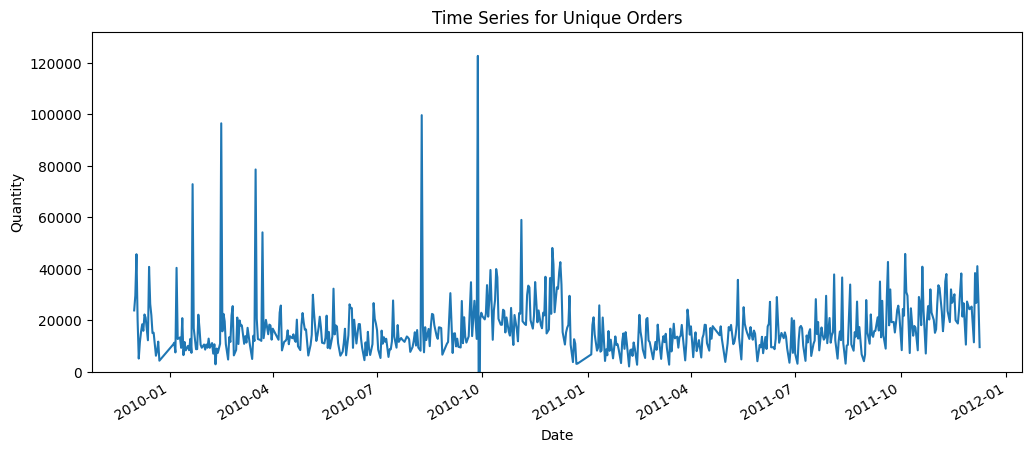

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))
retail_cleaned.groupby('ds')['y'].sum().sort_index().plot()
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Time Series for Unique Orders')
fig.autofmt_xdate()
plt.ylim(bottom=0)

In [42]:
inflection_date = datetime.datetime(2011, 10, 15)
train_df = retail_cleaned[retail_cleaned['ds'] < inflection_date]
test_df = retail_cleaned[retail_cleaned['ds'] >= inflection_date]

In [47]:
test_df['ds'].nunique()

48

In [25]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    AutoETS,
    AutoTheta,
    AutoCES,
    SeasonalNaive,
)

In [74]:
# Define a list of models for forecasting
models = [
    MSTL(
        season_length=[
            30,
            365, ],  # seasonalities, currently weekly monthly (eom) and annually
        trend_forecaster=AutoARIMA(),
        alias='MSTL_ARIMA'  # model used to forecast individual trend
    ),
    MSTL(
        season_length=[
            30,
            365, ],  # seasonalities, currently weekly monthly (eom) and annually
        trend_forecaster=AutoTheta(),
        alias='MSTL_Theta'  # model used to forecast individual trend
    ),
    MSTL(
        season_length=[
            30,
            365, ],  # seasonalities, currently weekly monthly (eom) and annually
        trend_forecaster=AutoCES(),
        alias='MSTL_CES'  # model used to forecast individual trend
    ),
    MSTL(
        season_length=[
            30,
            365, ],  # seasonalities, currently weekly monthly (eom) and annually
        alias='MSTL_ETS'  # model used to forecast individual trend
    )
]

In [75]:
# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=-1,  # number of jobs to run in parallel, -1 means using all processors
    fallback_model = SeasonalNaive(season_length=7)
)

In [76]:
prediction_df = sf.forecast(df=train_df, h=test_df['ds'].nunique()) # forecast data

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


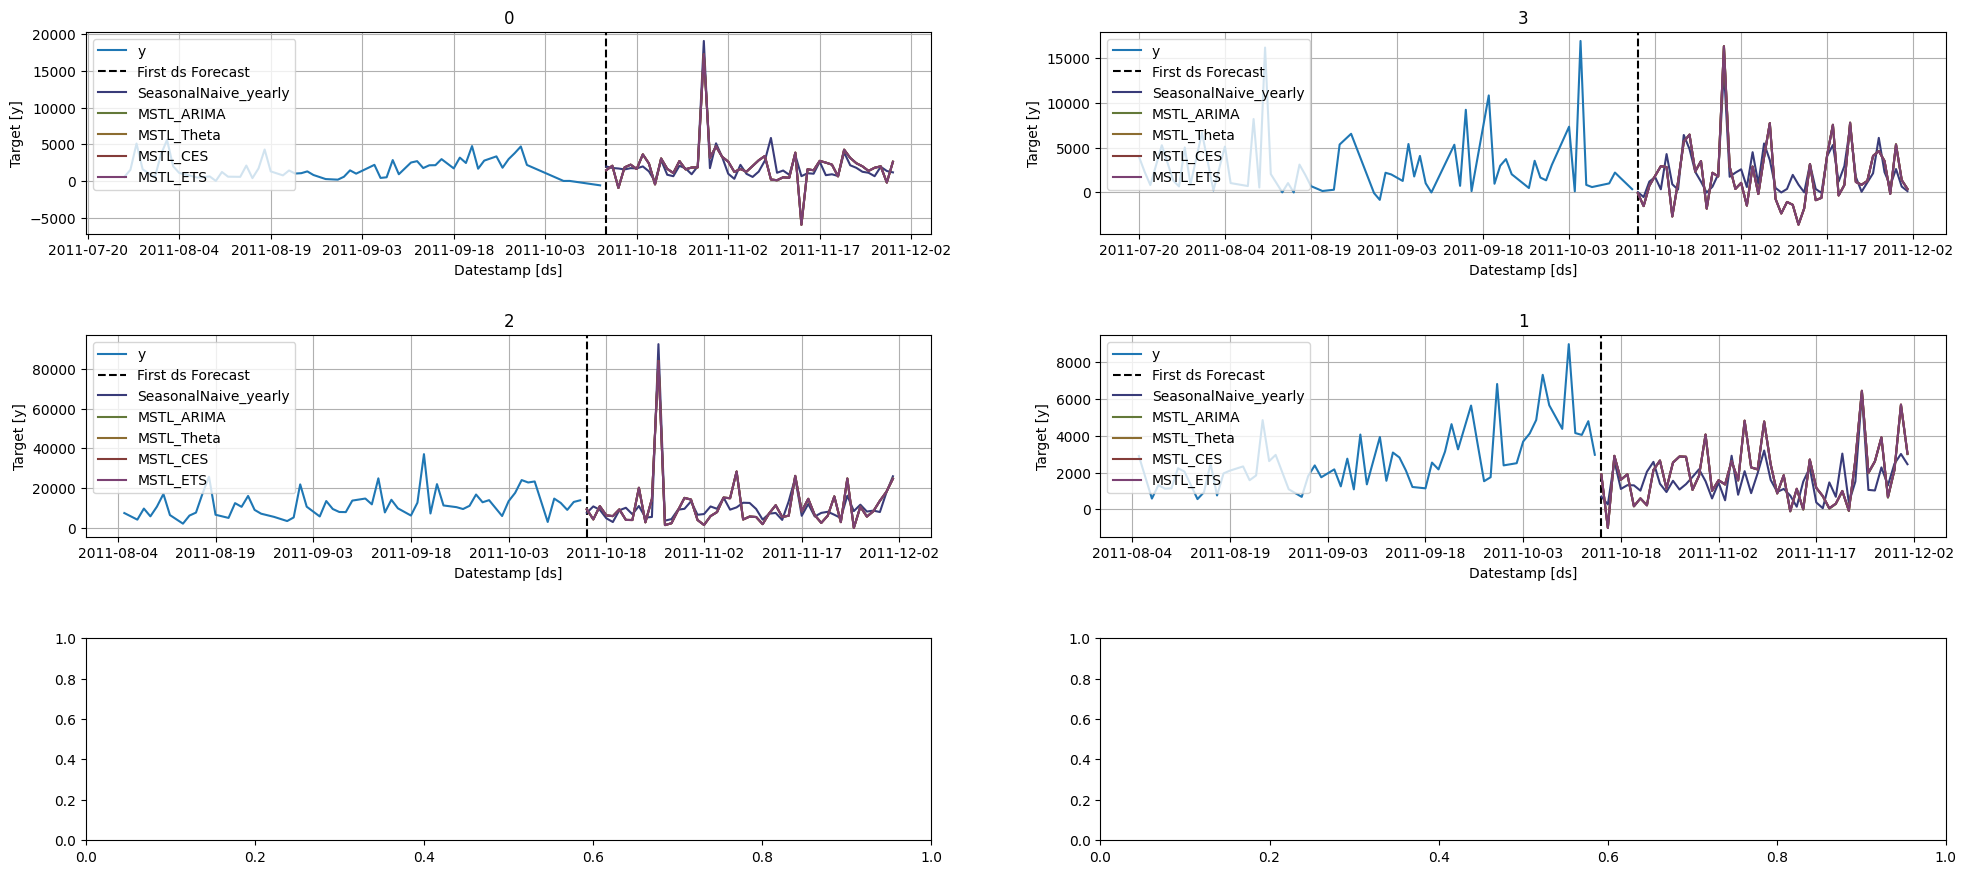

In [77]:
sf.plot(train_df, prediction_df, max_insample_length=60, engine='matplotlib')

In [78]:
crossvalidation_df = sf.cross_validation(
                                        df=train_df,
                                        h=45,
                                        step_size=60,
                                        n_windows=5
                                    )
crossvalidation_df

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


,ds,cutoff,y,SeasonalNaive_yearly,MSTL_ARIMA,MSTL_Theta,MSTL_CES,MSTL_ETS
unique_id,,,,,,,,
0,2011-01-01,2010-12-31,1314.0,NaN,1029.732178,1029.732056,1029.732178,1029.732178
0,2011-01-02,2010-12-31,1520.0,NaN,-160.418930,-160.419037,-160.418915,-160.418930
0,2011-01-03,2010-12-31,1450.0,NaN,726.990112,726.989990,726.990112,726.990112
0,2011-01-04,2010-12-31,764.0,NaN,-92.907227,-92.907349,-92.907227,-92.907227
0,2011-01-05,2010-12-31,814.0,NaN,1151.333496,1151.333374,1151.333496,1151.333496
...,...,...,...,...,...,...,...,...
3,2011-10-10,2011-08-30,588.0,4579.0,2247.046143,2208.844971,2222.315186,2208.132812
3,2011-10-11,2011-08-30,997.0,3005.0,908.222595,868.462219,882.282288,867.732605
3,2011-10-12,2011-08-30,2206.0,656.0,-2437.242676,-2478.577148,-2464.406006,-2479.324463


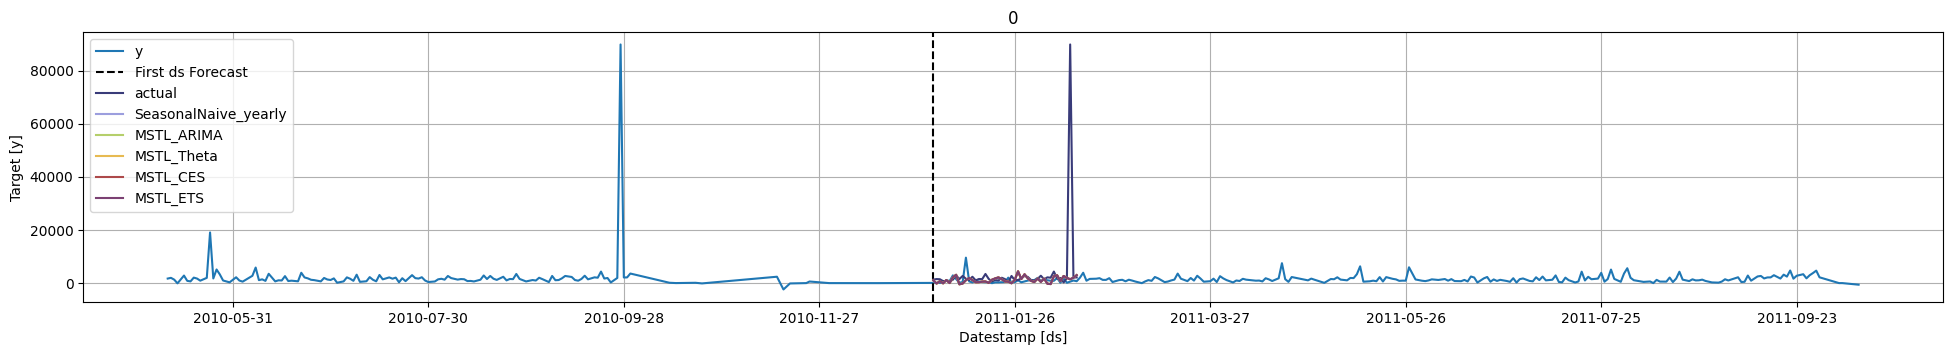

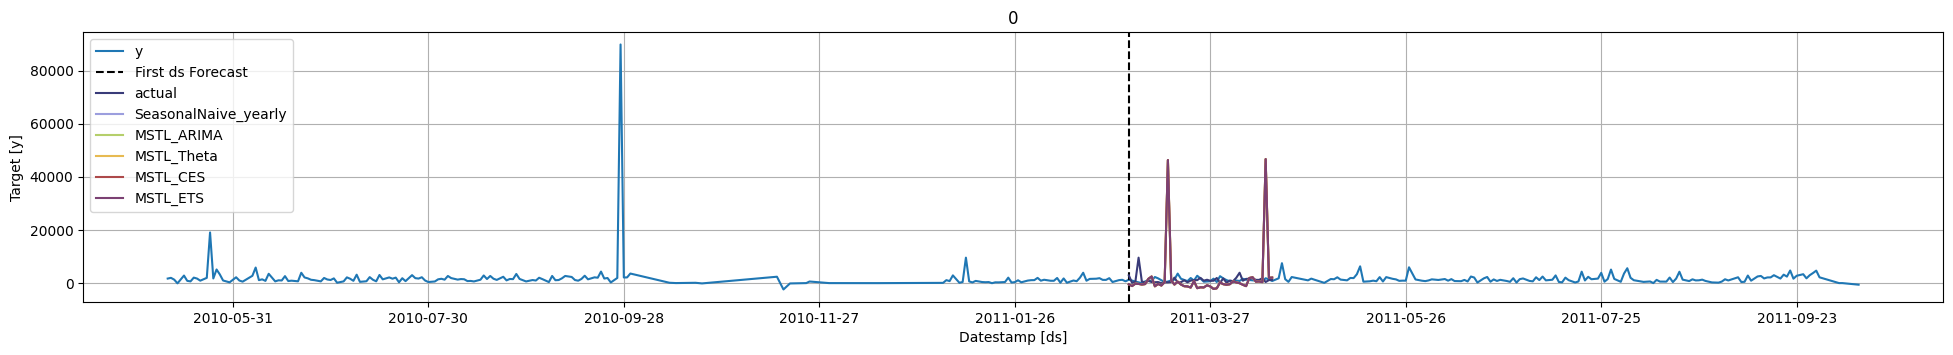

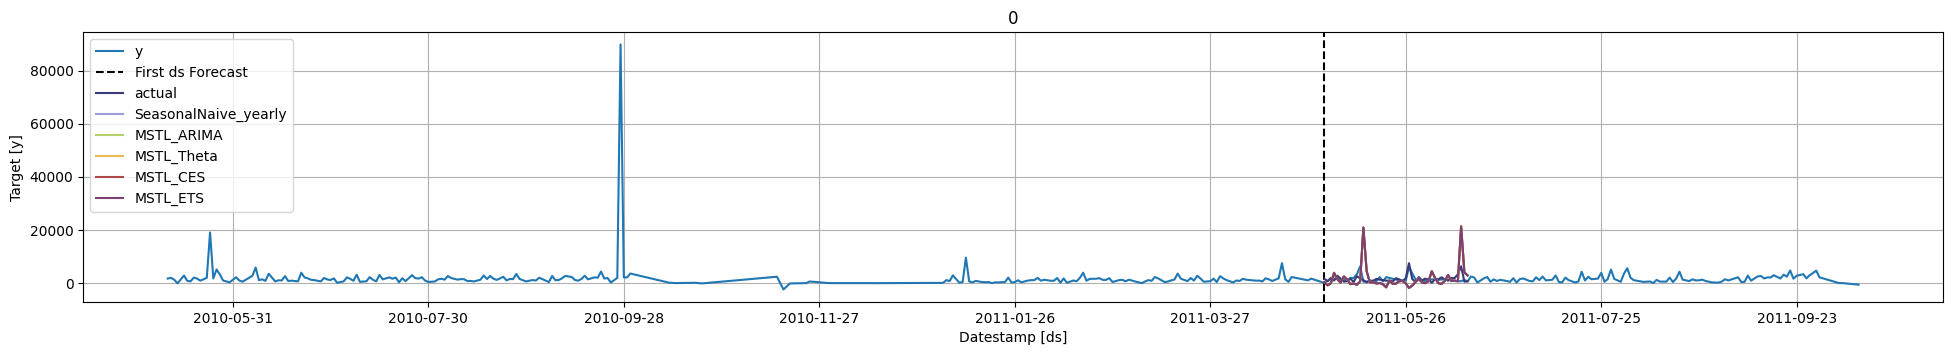

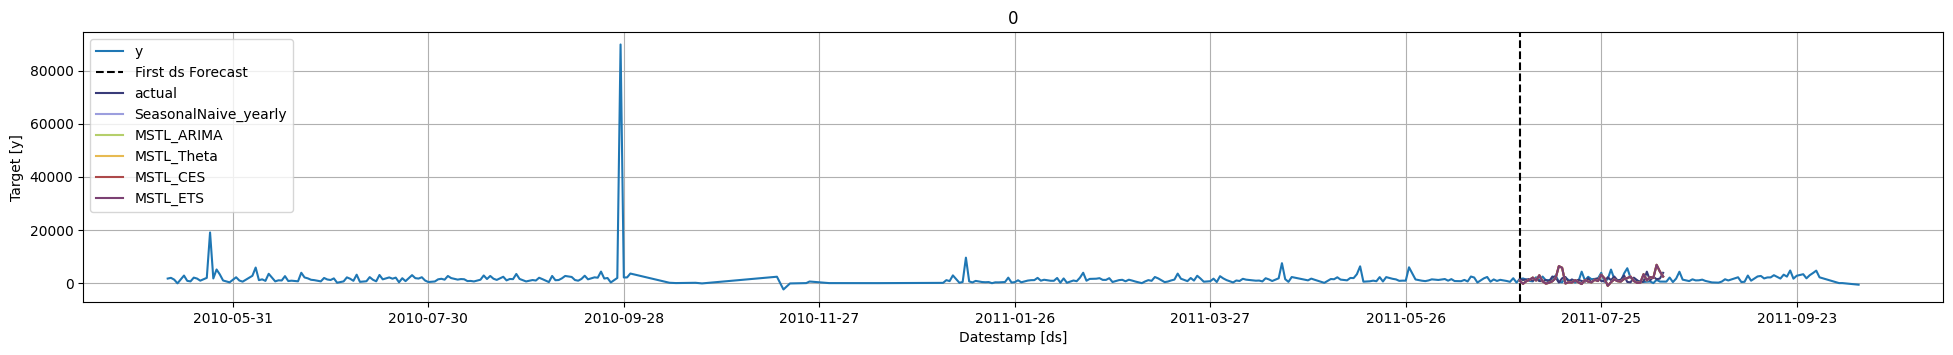

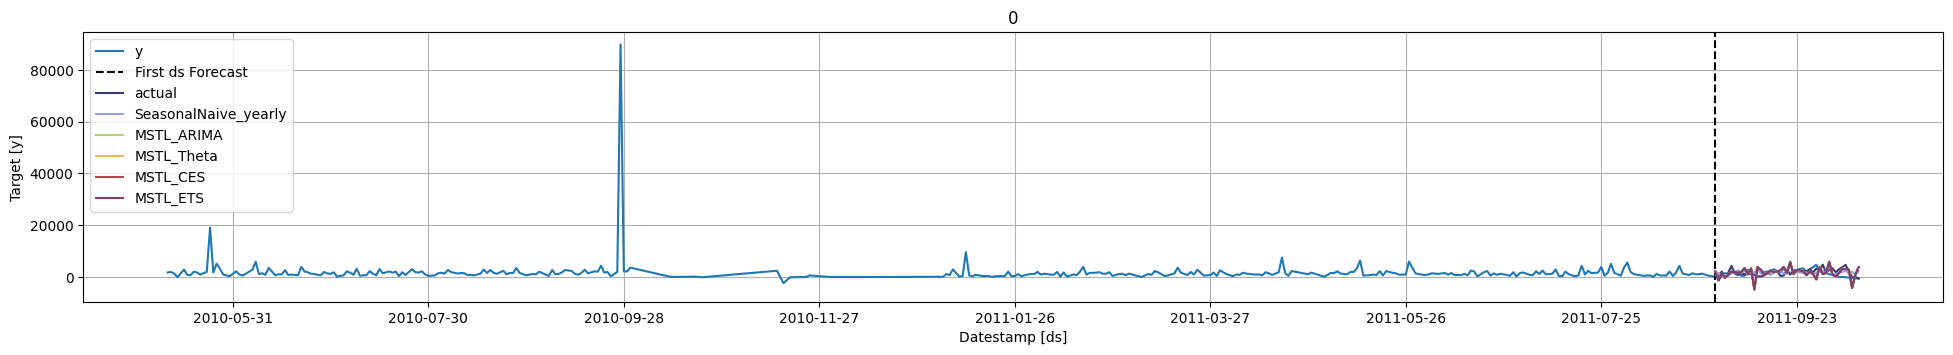

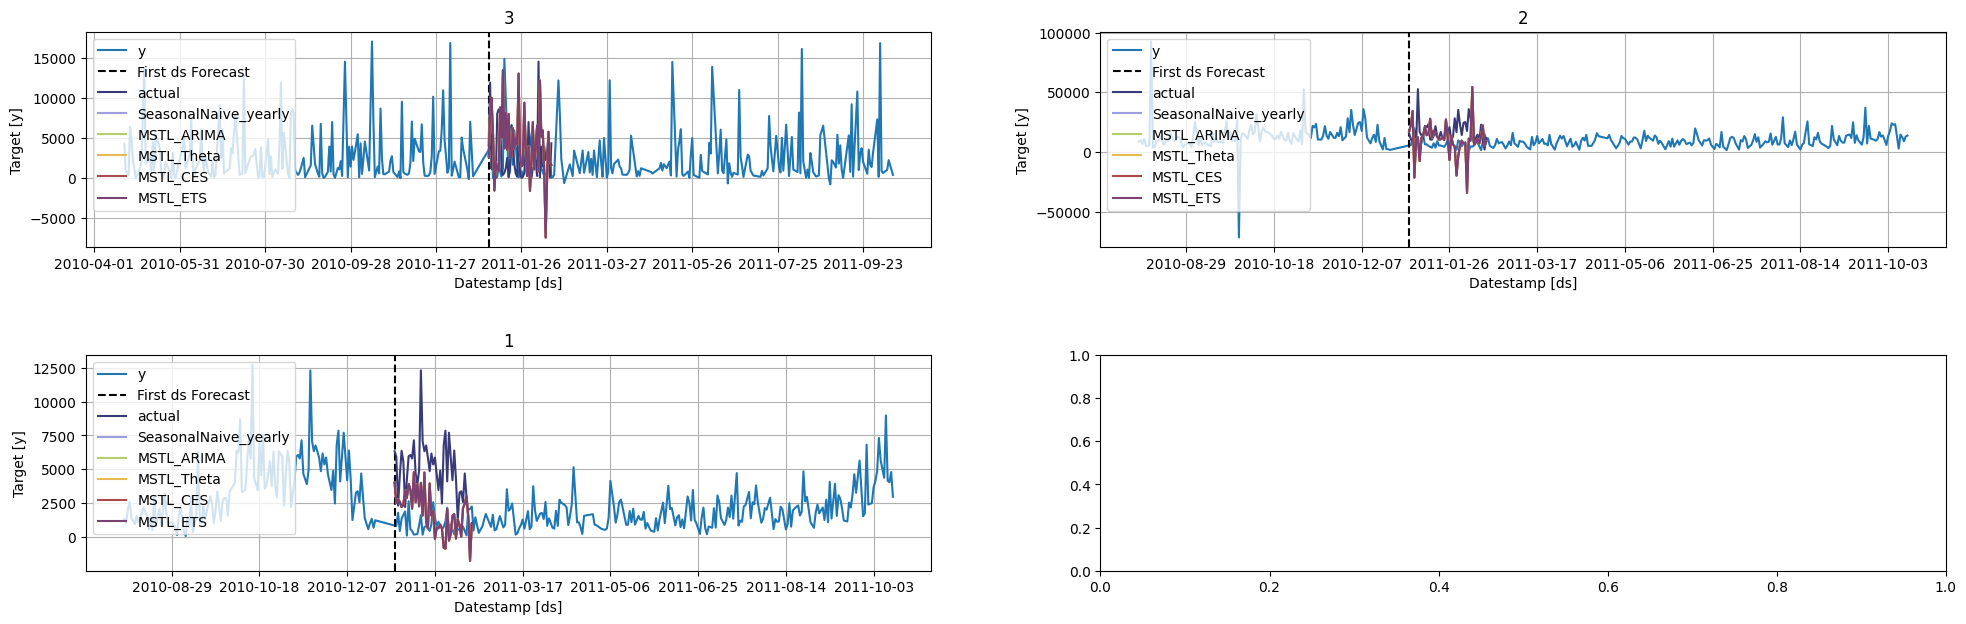

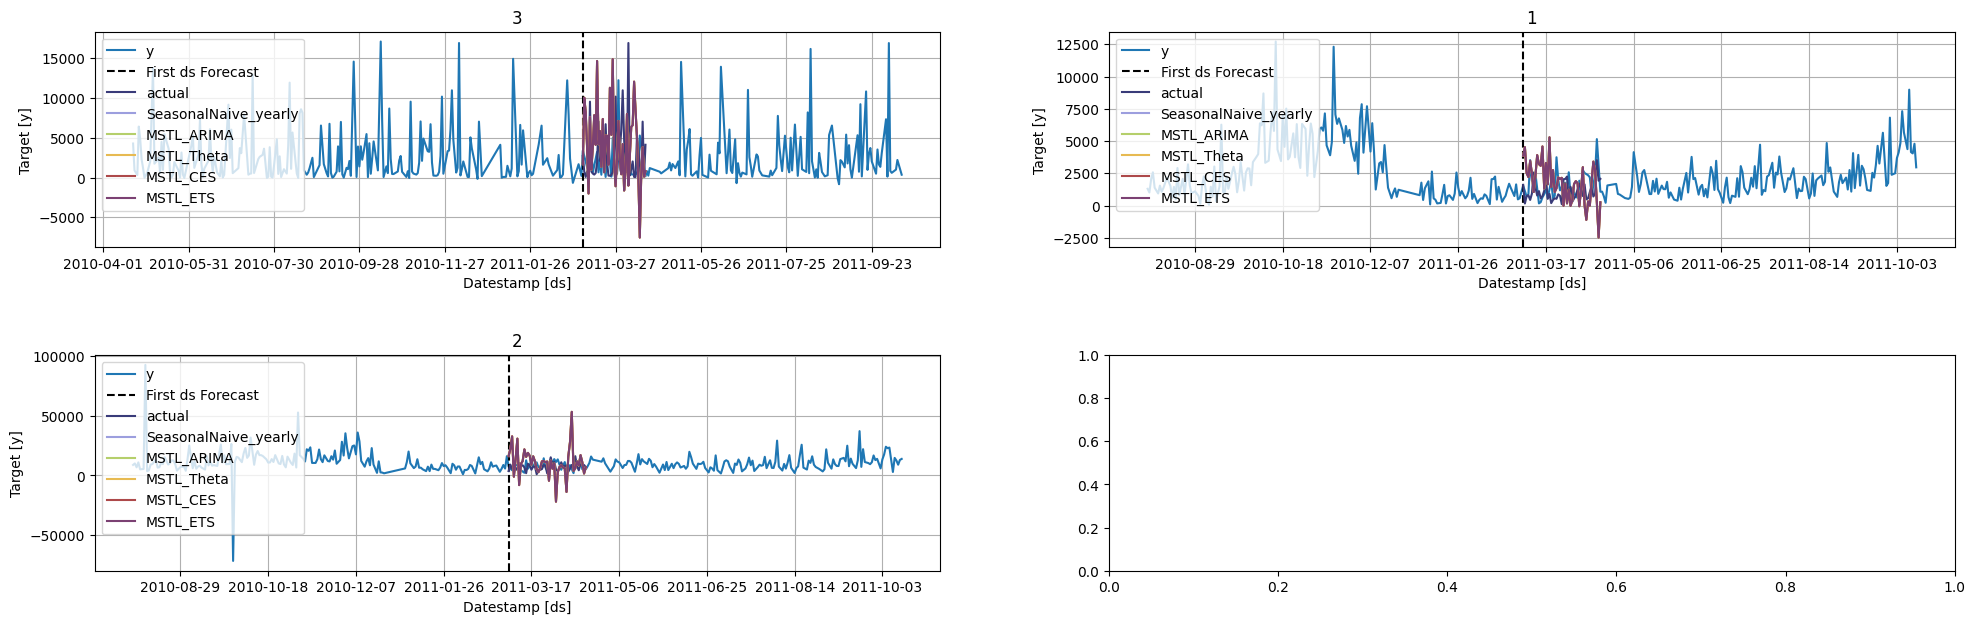

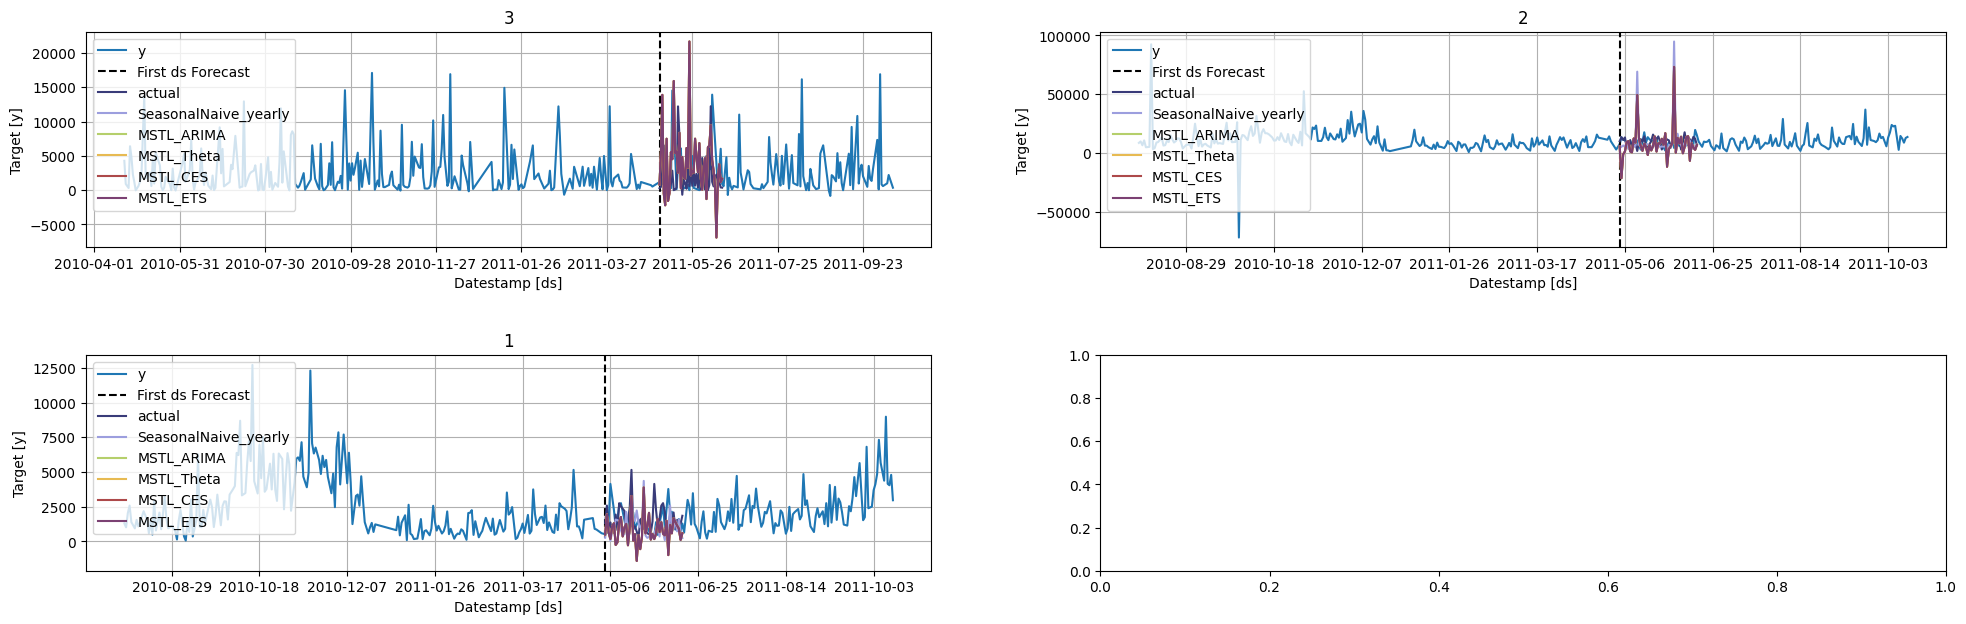

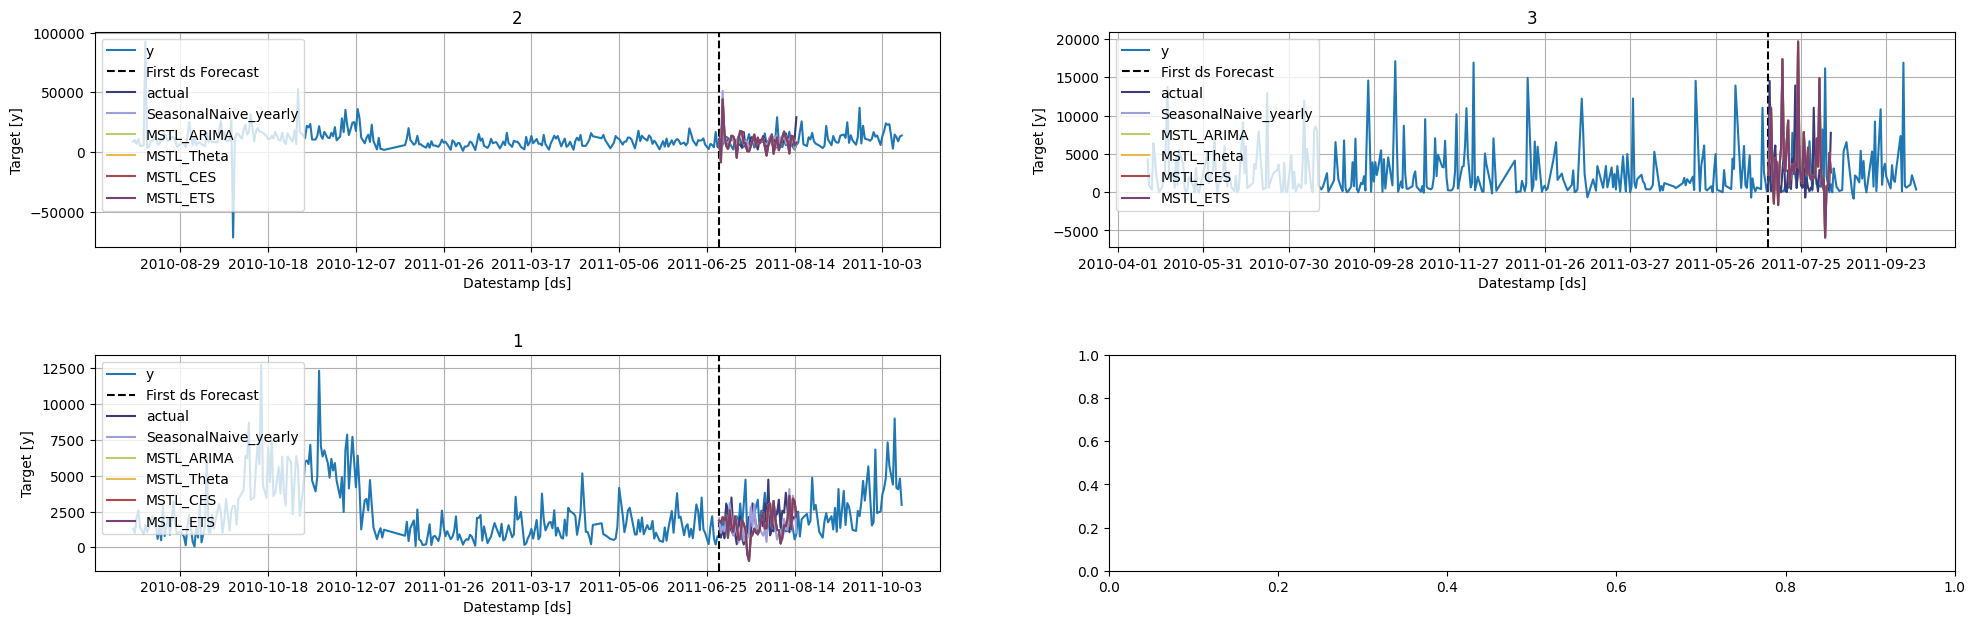

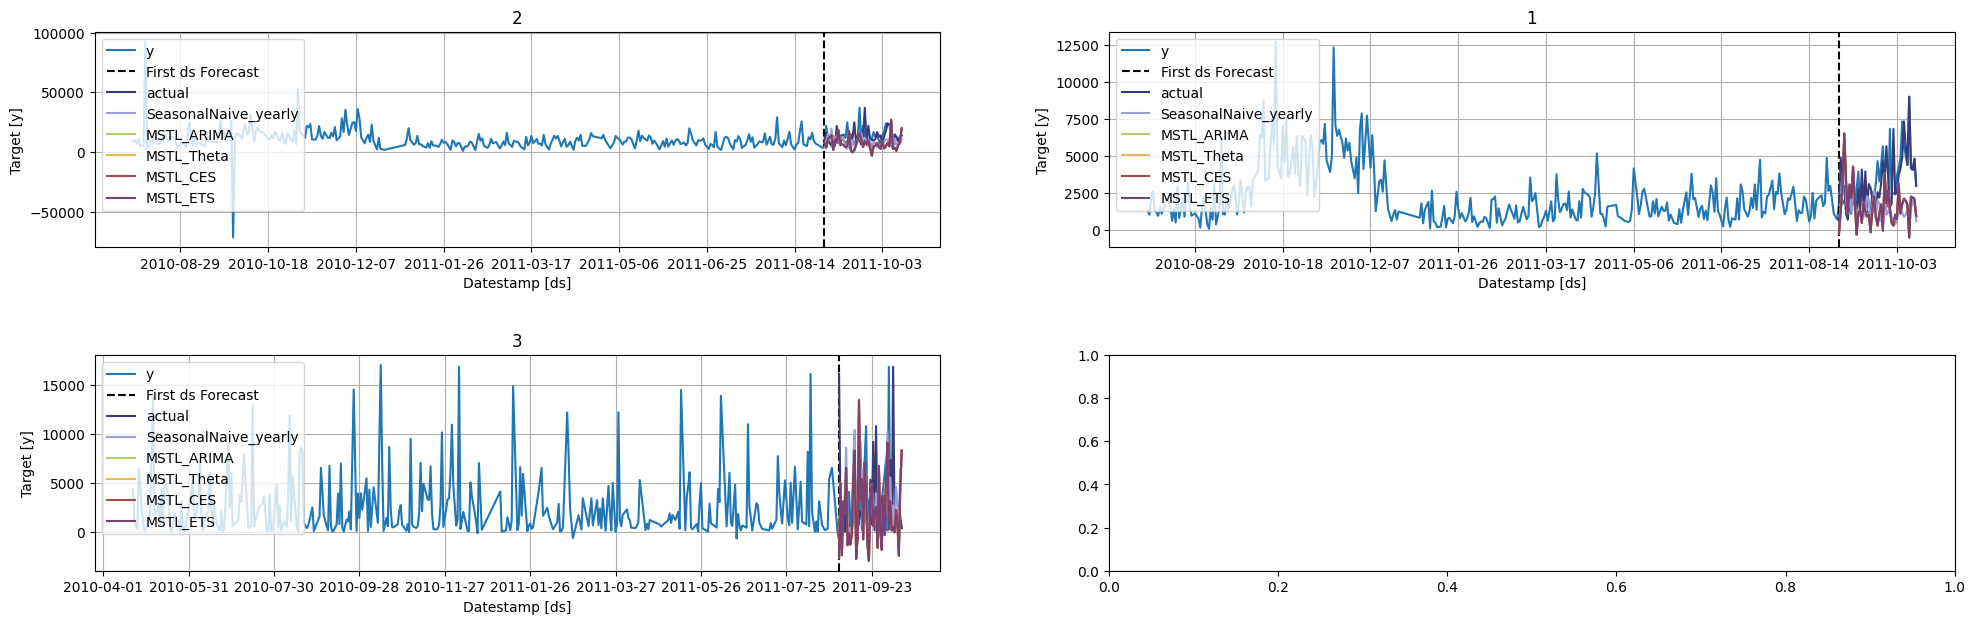

In [79]:
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values 

cutoff = crossvalidation_df['cutoff'].unique()

for k in range(len(cutoff)): 
    cv = crossvalidation_df[crossvalidation_df['cutoff'] == cutoff[k]]
    StatsForecast.plot(train_df, cv.loc[:, cv.columns != 'cutoff'], max_insample_length=360, engine='matplotlib')

In [80]:
# Group by day to calculate total transaction, MAE is a reliable metric here
# A little suprised that just the seasonal yearly term has a better MAPE?
all_results = []
for col in crossvalidation_df.iloc[:, 3:].columns:
    result = {}
    cv_grouped = crossvalidation_df.groupby('ds', as_index=False)
    result['Model'] = col
    result['MAE'] = mean_absolute_error(cv_grouped[col].sum()[col], cv_grouped['actual'].sum()['actual'])
    result['MAPE'] = mean_absolute_percentage_error(cv_grouped[col].sum()[col], cv_grouped['actual'].sum()['actual'])

    all_results.append(result)

In [86]:
results_df = pd.DataFrame(all_results)
results_df['MAPE'] = results_df['MAPE'].round(2)
results_df

,Model,MAE,MAPE
0,SeasonalNaive_yearly,13184.927734,3.527612e+19
1,MSTL_ARIMA,12269.892578,2.410000e+00
2,MSTL_Theta,12279.658203,2.430000e+00
3,MSTL_CES,12277.039062,2.420000e+00
4,MSTL_ETS,12279.857422,2.430000e+00
